In [1]:
import os
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import torch

from flyvis.datasets.rendering import BoxEye
from flyvis.analysis.animations import HexScatter
import pandas as pd

import h5py
import datamate.io        # Where the function is defined
import datamate.directory # Where the function is actually CALLED causing the error

data_path = Path("data/flyvis_data")
data_path.mkdir(parents=True, exist_ok=True)

env = os.environ.copy()
env["FLYVIS_ROOT_DIR"] = str(data_path)

In [2]:
def fixed_write_h5(path, val):
    """
    A Windows-safe replacement that skips the 'read-before-write' check.
    """
    path = Path(path)
    path.parent.mkdir(parents=True, exist_ok=True)

    # Simple, safe write. No checking 'f["data"]', no 'unlink'.
    # This completely bypasses the logic causing your KeyError.
    with h5py.File(path, mode="w", libver="latest") as f:
        f.create_dataset("data", data=val)

# --- STEP 2: APPLY THE PATCH EVERYWHERE ---
print("Applying aggressive patches...")

# Patch 1: The definition
datamate.io._write_h5 = fixed_write_h5

# Patch 2: The copy inside directory.py (THIS IS THE KEY FIX)
# This forces the Directory class to use OUR function, not the old one it imported.
if hasattr(datamate.directory, "_write_h5"):
    datamate.directory._write_h5 = fixed_write_h5
    print(" -> Patched datamate.directory._write_h5")
else:
    print(" -> Warning: Could not find _write_h5 in directory module")


print("Importing flyvis...")
from flyvis import NetworkView


Applying aggressive patches...
 -> Patched datamate.directory._write_h5
Importing flyvis...


In [3]:
network_view = NetworkView(data_path / "results/flow/0000/000")

[2026-01-07 18:18:48] network_view:122 Initialized network view at C:\Users\dean\Documents\dev\fly_winter_school\fly_wire_perturbations\data\flyvis_data\results\flow\0000\000


In [4]:
cell_type_df = pd.read_csv(f'{data_path}/flyvis_cell_type_connectivity.csv')

In [5]:
# cell_type_df[cell_type_df.source_type == cell_type_df.target_type]

In [6]:
# cell_type_df[cell_type_df.target_type == 'T1']

### Pert 

In [7]:
# Now perturb
from flyvis_cell_type_pert import FlyvisCellTypePert, PerturbationType
pert = FlyvisCellTypePert()

pairs_to_perturb = [('C2', 'T1'), ('Am', 'T1')]

motif_id = "78 ['+', '+', '-', '-']"
pert.perturb(cell_type_df, PerturbationType.MOTIF, motif_id=str(motif_id))

# pert.perturb(
#     cell_type_df,
#     perturbation_type=PerturbationType.PAIR_WISE,
#     pairs=pairs_to_perturb
# )

print("Perturbed connections:")
print(pert.pert_conn[pert.pert_conn.pert_weight == 0])

Perturbed connections:
    source_type target_type  sign  syn_count  pert_weight
16           C2          L5  -1.0        721            0
18           C2         Mi1  -1.0        721            0
30           C3          L5  -1.0        721            0
32           C3         Mi1  -1.0        721            0
42           C3         Tm1  -1.0        721            0
..          ...         ...   ...        ...          ...
562       TmY15         Tm4  -1.0       6121            0
563       TmY15         Tm9  -1.0       5399            0
584        TmY4         Mi4   1.0       1350            0
587        TmY4       TmY14   1.0       1350            0
595       TmY5a        Tm16  -1.0        659            0

[112 rows x 5 columns]


In [8]:
from copy import deepcopy

original_network = network_view.init_network()
perturbed_network = deepcopy(original_network)

# Check and apply perturbation
def get_pair_index_in_network(network, source_type, target_type):
    syn_str = network.edge_params.syn_strength.keys
    for idx, (src, tar) in enumerate(syn_str):
        if src == source_type and tar == target_type:
            return idx
    return None


for pair in pairs_to_perturb:
    print()
    idx = get_pair_index_in_network(original_network, pair[0], pair[1])
    print(f'{pair[0]} -> {pair[1]} index: {idx}')

    weight_original_before = original_network.edge_params.syn_strength.raw_values[idx].item()
    weight_pert_before = perturbed_network.edge_params.syn_strength.raw_values[idx].item()
    print(f'Original network {pair[0]}->{pair[1]} weight before: {weight_original_before}')
    print(f'Perturbed network {pair[0]}->{pair[1]} weight before: {weight_pert_before}')

# Apply perturbatio
print('applying perturbation...')
pert.override_network(perturbed_network)
for pair in pairs_to_perturb:
    print()
    idx = get_pair_index_in_network(original_network, pair[0], pair[1])
    print(f'{pair[0]} -> {pair[1]} index: {idx}')

    weight_pert_after = perturbed_network.edge_params.syn_strength.raw_values[idx].item()
    weight_original_after = original_network.edge_params.syn_strength.raw_values[idx].item()
    print(f'Original network {pair[0]}->{pair[1]} weight after (should be unchanged): {weight_original_after}')
    print(f'Perturbed network {pair[0]}->{pair[1]} weight after: {weight_pert_after}')


[2026-01-07 18:18:48] logging_utils:23 epe not in C:\Users\dean\Documents\dev\fly_winter_school\fly_wire_perturbations\data\flyvis_data\results\flow\0000\000\validation, but 'loss' is. Falling back to 'loss'. You can rerun the ensemble validation to make appropriate recordings of the losses.
[2026-01-07 18:18:51] network:222 Initialized network with NumberOfParams(free=734, fixed=2959) parameters.
[2026-01-07 18:18:51] chkpt_utils:36 Recovered network state.



C2 -> T1 index: 140
Original network C2->T1 weight before: 4.58910217275843e-05
Perturbed network C2->T1 weight before: 4.58910217275843e-05

Am -> T1 index: 131
Original network Am->T1 weight before: 0.003842476522549987
Perturbed network Am->T1 weight before: 0.003842476522549987
applying perturbation...

C2 -> T1 index: 140
Original network C2->T1 weight after (should be unchanged): 4.58910217275843e-05
Perturbed network C2->T1 weight after: 4.58910217275843e-05

Am -> T1 index: 131
Original network Am->T1 weight after (should be unchanged): 0.003842476522549987
Perturbed network Am->T1 weight after: 0.003842476522549987


### Plot neural traces

In [9]:
#supply random stimulus
from flyvis.utils.hex_utils import get_num_hexals

# Stimulation time and time step
T = 1  # seconds
dt = 1 / 50  # 1 / 200

# Create a random stimulus
stimulus = torch.randn(
    1, int(T / dt), 1, get_num_hexals(original_network.connectome.config.extent)
)

# Add the stimulus to a stimulus buffer
# For now, do this in parallel to original and perturbed networks
original_network.stimulus.add_input(stimulus)
perturbed_network.stimulus.add_input(stimulus)
# Run the model
with torch.no_grad():
    original_activity = original_network(original_network.stimulus(), dt=dt)
    perturbed_activity = perturbed_network(perturbed_network.stimulus(), dt=dt)

In [10]:
print("Shape of the original network activity:", original_activity.shape)
print("Shape of the perturbed network activity:", perturbed_activity.shape )

Shape of the original network activity: torch.Size([1, 50, 45669])
Shape of the perturbed network activity: torch.Size([1, 50, 45669])


In [11]:
from flyvis.utils.activity_utils import LayerActivity as ActivityByType

original_activity_by_type = ActivityByType(original_activity, original_network.connectome, keepref=True)
perturbed_activity_by_type = ActivityByType(perturbed_activity, perturbed_network.connectome, keepref=True)
print("Shape of the activity:", original_activity_by_type.T1[:].shape)

Shape of the activity: torch.Size([1, 50, 721])


In [14]:
original_activity_by_type

Activity of: 
R1, R2, R3, R4, R5, R6, R7, R8, L1, L2, L3, L4, L5, Lawf1, Lawf2, Am,
C2, C3, CT1(Lo1), CT1(M10), Mi1, Mi2, Mi3, Mi4, Mi9, Mi10, Mi11, Mi12,
Mi13, Mi14, Mi15, T1, T2, T2a, T3, T4a, T4b, T4c, T4d, T5a, T5b, T5c,
T5d, Tm1, Tm2, Tm3, Tm4, Tm5Y, Tm5a, Tm5b, Tm5c, Tm9, Tm16, Tm20,
Tm28, Tm30, TmY3, TmY4, TmY5a, TmY9, TmY10, TmY13, TmY14, TmY15, TmY18

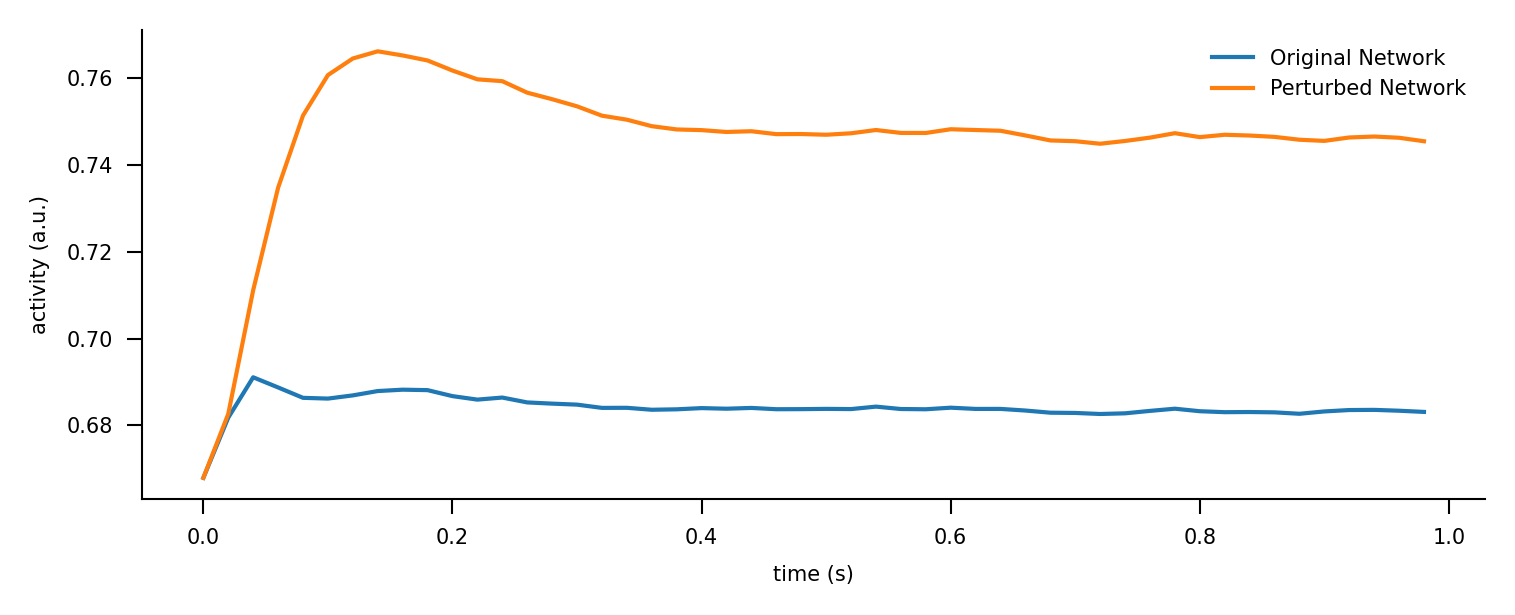

In [15]:
time = np.arange(0, original_activity.shape[1]) * dt
# neuron_idx = 50

fig ,ax  = plt.subplots(1,1, figsize=(5, 2))
ax.plot(time, original_activity_by_type.Mi11.mean(dim=2).squeeze().cpu(), label='Original Network')
ax.set_xlabel("time (s)")
ax.set_ylabel("activity (a.u.)")

ax.plot(time, perturbed_activity_by_type.Mi11.mean(dim=2).squeeze().cpu(), label='Perturbed Network')
ax.legend()
plt.tight_layout()

### Plot response to Sintel movie set (naturalistic stimuli)